# **Data Mining and Machine Learning - Team Tissot**

**Detecting the difficulty level of French texts**

**Word2Vec**

In this notebook we attempted to achieve greater accuracy by using Word2Vec


#  1. Importing packages and data

In [1]:
# Importing packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from wordcloud import WordCloud   
sns.set_style("whitegrid")

# import some additional packages for training models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords  
nltk.download('punkt')

# import tqdm (progress bar)
from tqdm import tqdm

# import files to download .csv
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Importing packages for tokenization

# Install and update spaCy
!pip install -U spacy

# Download the french language model
!python -m spacy download fr_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2022-12-21 09:12:43.480140: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 5.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [3]:
# Import required packages from spacy
import spacy
from spacy import displacy

#Load French language model
sp = spacy.load("fr_core_news_sm")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


> Additional custom functions from our github repo


In [4]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import requests

In [6]:
url = 'https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py'
r = requests.get(url)

# make sure your filename is the same as how you want to import 
with open('custom_functions.py', 'w') as f:
    f.write(r.text)
print(r.text)
# now we can import
import custom_functions as cfun

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import files
from tqdm import tqdm
from nltk.corpus import stopwords        
from nltk.tokenize import word_tokenize, sent_tokenize 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string


import spacy
from spacy import displacy
sp = spacy.load("fr_core_news_sm")


def evaluate(true, pred):
    precision = precision_score(true, pred, average = 'weighted')
    recall = recall_score(true, pred, average = 'weighted')
    f1 = f1_score(true, pred, average = 'weighted')
    acc = accuracy_score(true, pred)
    index = 'result'
    d = {'accuracy': round(acc,4), 'precision': round(precision,4), 'recall': round(recall,4), 'f1 score': round(f1,4) }
    df = pd.DataFrame(d,index=["results"])
    sns.heatmap(pd.DataFrame(confusion_matrix(true, pre

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [7]:
# training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

---

# 2. Setting up Word2Vec

First, let's define a spacy tokenizer

In [214]:
import string

def spacy_tokenizer(sentence):
    doc = sp(sentence)
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS
    punctuations = string.punctuation
    numbers = "0123456789"
  
    mytokens = [ word.lower_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in doc ]
    mytokens = [ word for word in mytokens if word not in punctuations and word not in stop_words ]
    return mytokens_2

> This tokenizer transform words into tokens that are lowercase and not part of nltk french stopwords.

Next, let's gather some additional information about the sentences using our [custom function](https://)





In [127]:
dfTrainInfo = cfun.get_info(dfTrain) 

100%|██████████| 4800/4800 [00:42<00:00, 111.65it/s]


In [128]:
dfTrainInfo

,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg,number_of_words_after_lemma_stop,longest_word_size
0,255,1,38,38.0,6.710526,23,16
1,62,1,12,12.0,5.166667,5,8
2,66,1,13,13.0,5.076923,6,8
3,40,1,8,8.0,5.000000,3,6
4,209,1,36,36.0,5.805556,19,11
...,...,...,...,...,...,...,...
4795,165,1,26,26.0,6.346154,12,12
4796,118,1,21,21.0,5.619048,9,10
4797,80,1,13,13.0,6.153846,6,11
4798,226,1,32,32.0,7.062500,16,16


> `text_length`: Character length the text.  
> `number_of_sentences`: How many sentences are in the text.  
> `number_of_words`:  adssda   
> `sent_length_avg`:     
> `words_length_avg`:    
> `number_of_words_after_lemma_stop`:     
> `longest_word_size`:   

**Tokenizing every words in dfTrain and dfTest to feed it as vocabulary to Word2Vec**

In [215]:
# Tokenizing texts in dfTrain
processed_texts = []
for text in tqdm(dfTrain["sentence"]):
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

100%|██████████| 4800/4800 [00:42<00:00, 112.09it/s]


In [216]:
len(processed_texts)

4800

In [217]:
# Tokenize texts in dfTrain
processed_texts_test = []
for text in tqdm(dfTest["sentence"]):
  processed_text_test = spacy_tokenizer(text)
  processed_texts_test.append(processed_text_test)

100%|██████████| 1200/1200 [00:10<00:00, 114.23it/s]


In [218]:
len(processed_texts_test)

1200

In [219]:
# Merging both lists of tokens
processed_texts_both = processed_texts + processed_texts_test

In [220]:
len(processed_texts_both)

6000

In [221]:
# import package for Word2Vec
import gensim

In [222]:
# Necessary function to set a fixed random state to Word2Vec
def hash(astring):
   return ord(astring[0])

In [223]:
processed_texts_both

[['coûts',
  'kilométriques',
  'réels',
  'diverger',
  'sensiblement',
  'valeurs',
  'moyennes',
  'fonction',
  'moyen',
  'transport',
  'utilisé',
  'taux',
  'occupation',
  'taux',
  'remplissage',
  'infrastructure',
  'utilisée',
  'topographie',
  'lignes',
  'flux',
  'trafic',
  'etc.'],
 ['bleu', 'couleur', 'préférée', 'aime', 'vert'],
 ['test', 'niveau', 'français', 'site', 'internet', 'école'],
 ['-ce', 'mari', 'boston'],
 ['écoles',
  'commerce',
  'couloirs',
  'places',
  'financières',
  'arrive',
  "aujourd'hui",
  'croiser',
  'jeunes',
  'adultes',
  'ans',
  'prévoient',
  'ouvrir',
  'maison',
  'hôtes',
  'quinzaine',
  'années'],
 ['histoire', 'beaucoup', 'aimée'],
 ['médecins', 'disent', 'boire', 'verre', 'vin', 'rouge', 'repas'],
 ['particulièrement',
  'observé',
  'personnes',
  'besoin',
  'popularité',
  'développé',
  'considèrent',
  'moindre',
  'signal',
  'smartphone',
  'indicateur',
  'degré',
  'popularité'],
 ['retrouvé', 'plaisir', 'manger', '

In [224]:
# Building Word2Vec model
model = gensim.models.Word2Vec(size=128, window=50, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)
# train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=300)

(15054991, 15103500)

**Building dataframe with vectors**

In [225]:
# Applying Word2Vec vectorizer to every sentence in dfTrain
vectors = []
for sent in tqdm(processed_texts):
    if len(sent) == 0:
      vectors.append(np.zeros(128))
    else:
      vectors.append(sum(model[token] for token in sent)/len(sent))


  0%|          | 0/4800 [00:00<?, ?it/s]<ipython-input-225-690c4e85c5e0>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 4800/4800 [00:00<00:00, 21937.17it/s]


In [226]:
# vectors to Dataframe
dfVectors = pd.DataFrame(vectors)

In [227]:
# Concatenating vectors and info dataframes
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

In [228]:
dfFinal

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,text_length,number_of_sentences,number_of_words,sent_length_avg,words_length_avg,number_of_words_after_lemma_stop,longest_word_size
0,-0.487369,0.376862,0.721048,-1.178557,-0.497942,0.162719,-2.183121,-0.691725,0.245411,-0.420044,...,0.581905,-1.792204,-0.610453,255,1,38,38.0,6.710526,23,16
1,0.238820,0.912931,1.518265,-1.186823,1.148972,0.387363,-1.358125,0.038058,0.809193,-1.314494,...,-0.056090,1.322231,0.735640,62,1,12,12.0,5.166667,5,8
2,-1.771312,0.277783,1.689141,0.567162,1.928350,-0.003533,-0.037658,0.054710,0.660261,-0.997537,...,-1.463819,-2.069563,-0.420919,66,1,13,13.0,5.076923,6,8
3,0.353038,0.772674,0.808723,0.384813,0.851862,-0.307960,-2.090595,0.298239,-1.182643,-0.896568,...,-0.994940,-0.226338,1.228986,40,1,8,8.0,5.000000,3,6
4,-0.489716,0.604773,-0.719505,-0.376249,0.965882,0.079475,-0.403868,0.995704,-0.672445,-1.146010,...,-0.219006,0.026327,0.046484,209,1,36,36.0,5.805556,19,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,-1.393899,-0.097372,1.485131,-0.908978,0.615483,0.113628,0.409821,0.605647,0.083297,-1.222872,...,-0.041615,0.150766,-0.092130,165,1,26,26.0,6.346154,12,12
4796,-0.143116,0.797687,1.324102,-1.658384,0.835905,0.330045,-0.209468,-0.253325,1.014415,-0.157671,...,-0.901291,0.367229,0.031336,118,1,21,21.0,5.619048,9,10
4797,0.241248,2.034385,0.308163,0.644982,0.782496,1.194951,-1.545435,1.768818,-0.343575,-0.732116,...,0.049328,0.012165,0.215479,80,1,13,13.0,6.153846,6,11
4798,-0.759086,0.312492,0.575685,-1.228673,0.314788,-2.034100,-1.376686,-0.931560,0.712727,-0.371310,...,0.324773,-0.592612,-1.579466,226,1,32,32.0,7.062500,16,16


# 3. Training a model using Word2Vec and LogisticRegression

In [229]:
from sklearn.linear_model import LogisticRegression

In [230]:
# train logistic regression model
X = dfFinal
y = dfTrain['difficulty']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fitting using a LogisticRegression
clf = LogisticRegression(max_iter=10000, random_state = 0)
clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LogisticRegression(max_iter=10000, random_state=0)

In [231]:
y_pred_w2vLR = clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.4604,0.4669,0.4604,0.4589


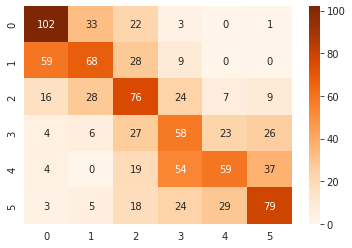

In [232]:
cfun.evaluate(y_test, y_pred_w2vLR)

# 4. Searching Best Word2Vec Parameters with Logistic Regression

Creating a list of different parameters combinations for word2vec 

In [ ]:
# Create list of configs
def configs():

    models = list()
    
    # Define config lists
    size = [32,128,256,512]
    window = [10,50,100]
    epochs = [10,50,100,300]

    
    # Create config instances
    for n in size:
        for i in window:
            for j in epochs:
                cfg = [n, i, j]
                models.append(cfg)
    return models
configs = configs()
configs

In [ ]:
# Looping through every Word2Vec configuration set by configs, and train the data with a Logistic Regression

result = []
for config in tqdm(configs):


    model = gensim.models.Word2Vec(size=config[0], window=config[1], min_count=1, workers=1, seed = 0, hashfxn=hash)
    model.build_vocab(processed_texts_both)
    # train model on preprocessed sentences
    model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=config[2])

    #vectorize using word2vec
    vectors = []
    for sent in processed_texts:
        if len(sent) == 0:
          vectors.append(np.zeros(config[0]))
        else:
          vectors.append(sum(model[token] for token in sent)/len(sent))

    #final dataframe
    dfVectors = pd.DataFrame(vectors)
    dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

    #Logistic Regression
    # train logistic regression model
    X = dfFinal
    y = dfTrain['difficulty']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    clf = LogisticRegression(max_iter=10000, random_state = 0)
    clf.fit(X_train, y_train)

    #predictions
    y_pred = clf.predict(X_test)
    print("CONFIG: ", config)
    print(accuracy_score(y_test, y_pred))
    print("\n-----------------------")
    result.append([config, accuracy_score(y_test, y_pred)])

In [ ]:
result.sort(key=lambda x: x[1], reverse=True)
word2vecTuningDF = (pd.DataFrame(result)).rename(columns = {0:'config', 1: 'accuracy'})

Taking a look at the best results in terms of accuracy:

In [ ]:
word2vecTuningDF.head()

,config,accuracy
0,"[256, 50, 300]",0.493750
1,"[32, 10, 300]",0.492708
2,"[32, 50, 300]",0.492708
3,"[256, 10, 300]",0.492708
4,"[512, 10, 300]",0.492708


In [ ]:
word2vecTuningDF.to_csv('a.csv')

Fitting the model once more with the best word2vec parameters